# Setup

In [16]:
%run ../../setup.ipynb

# Carico dati

In [17]:
# cartella dove ci sono i dati da analizzare
folder = "../../setup_dati/"

# importo dati
df_all = pd.read_csv(folder+"df_all_data.csv", sep=',').drop(columns=['Unnamed: 0'])
df_all["doc_index"] = df_all["doc_index"].apply(str)

In [18]:
df_all = calcola_scarto(df_all)

# Analisi

Poichè sto analizzando gli statement e nel dataset df_all ho tante occorrenze dello stesso (pocihè ognuno è stato valutato da 10 worker diversi) tengo 1 occorrenza di ciascuno

In [19]:
df_analisi = df_all.copy()

In [20]:
dimensioni_da_analizzare = ["doc_index", 
                            "doc_speaker_party",
                            "doc_statement_date"]

quartili = ["wrong_false", "correct_false", "wrong_true", "correct_true"]

### sistemo dati

In [21]:
for dimensione in dimensioni_da_analizzare:
    print(dimensione, len(df_analisi[dimensione].unique()))

doc_index 8
doc_speaker_party 2
doc_statement_date 66


In [22]:
df_analisi[dimensioni_da_analizzare].head()

,doc_index,doc_speaker_party,doc_statement_date
0,6.0,DEM,2022-03-15
1,7.0,DEM,2022-06-13
2,0.0,REP,2022-04-04
3,2.0,DEM,2022-05-27
4,3.0,DEM,2022-07-13


In [23]:
for index, row in df_analisi.iterrows():
    mese = row["doc_statement_date"]
    mese = float(mese[5:7])
    #row["doc_statement_date"] = mese
    df_analisi.at[index,"doc_statement_date"] = mese

In [24]:
for dimensione in dimensioni_da_analizzare:
    print(dimensione, len(df_analisi[dimensione].unique()))

doc_index 8
doc_speaker_party 2
doc_statement_date 11


In [25]:
df_analisi[dimensioni_da_analizzare].head()

,doc_index,doc_speaker_party,doc_statement_date
0,6.0,DEM,3.0
1,7.0,DEM,6.0
2,0.0,REP,4.0
3,2.0,DEM,5.0
4,3.0,DEM,7.0


### Frequenze relative

In [26]:
raccoglitore_dimensioni = crea_raccoglitore_dimensioni(df_analisi, dimensioni_da_analizzare, quartili)

In [27]:
raccoglitore_dimensioni["doc_speaker_party"]["wrong_true"]

,valore,freq_ass_all,freq_ass_sovra,freq_ass_quartile,freq_rel_all,freq_rel_sovra,freq_rel_quartile
0,DEM,650,120,0,0.542118,0.6,0.0
1,REP,549,80,50,0.457882,0.4,1.0


In [28]:
tabella_p_value = costruisci_tabella_pvalue_anova(raccoglitore_dimensioni, dimensioni_da_analizzare, quartili,ignora_per_ptrend = ["doc_speaker_party"])
significativi = filtra_siglificativi(tabella_p_value, dimensioni_da_analizzare, quartili, 0.05,"pvalue_quartile_sovra").sort_values(by=["dimensione"], ascending=True)
significativi

,dimensione,quartile,confronto,valore_pvalue,p_trend
4,doc_index,correct_false,pvalue_quartile_sovra,1.439862e-07,0.957123
1,doc_index,wrong_false,pvalue_quartile_sovra,2.948997e-07,0.796341
7,doc_index,wrong_true,pvalue_quartile_sovra,4.413737e-06,0.254276
10,doc_index,correct_true,pvalue_quartile_sovra,1.009877e-05,0.661959
27,doc_statement_date,wrong_true,pvalue_quartile_sovra,5.860746e-03,0.855613
30,doc_statement_date,correct_true,pvalue_quartile_sovra,7.632539e-03,0.73214
24,doc_statement_date,correct_false,pvalue_quartile_sovra,2.305939e-02,0.223715
21,doc_statement_date,wrong_false,pvalue_quartile_sovra,2.711725e-02,0.247785


In [29]:
raccoglitore_dimensioni["doc_index"]["correct_true"]

,valore,freq_ass_all,freq_ass_sovra,freq_ass_quartile,freq_rel_all,freq_rel_sovra,freq_rel_quartile
2,0.0,153,24,8,0.127606,0.120,0.133333
6,1.0,146,16,7,0.121768,0.080,0.116667
3,2.0,143,24,8,0.119266,0.120,0.133333
4,3.0,154,22,10,0.128440,0.110,0.166667
7,4.0,149,27,7,0.124270,0.135,0.116667
5,5.0,152,27,4,0.126772,0.135,0.066667
0,6.0,150,39,13,0.125104,0.195,0.216667
1,7.0,152,21,3,0.126772,0.105,0.050000


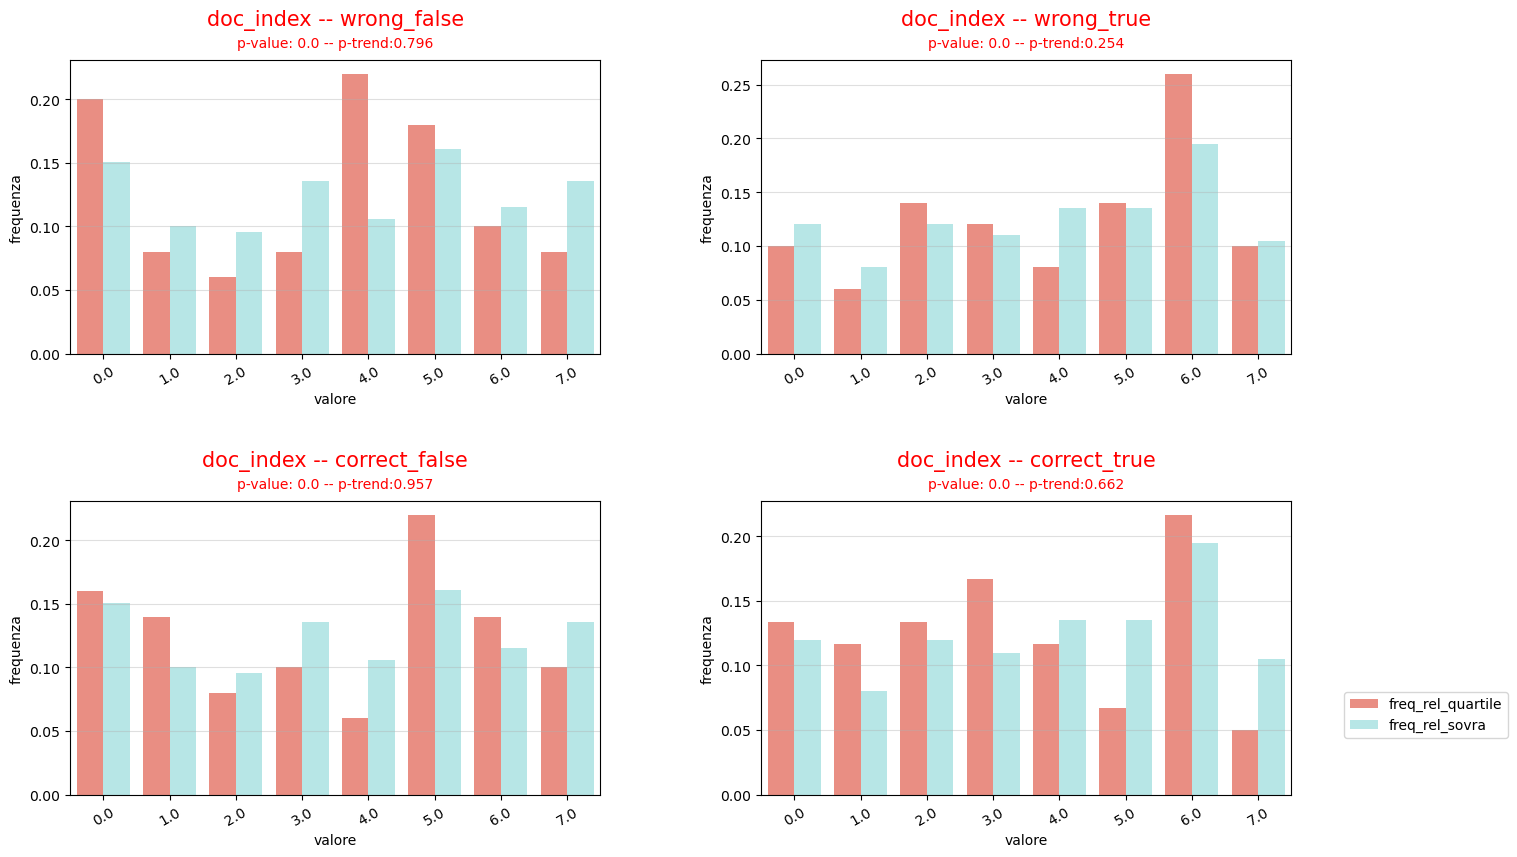

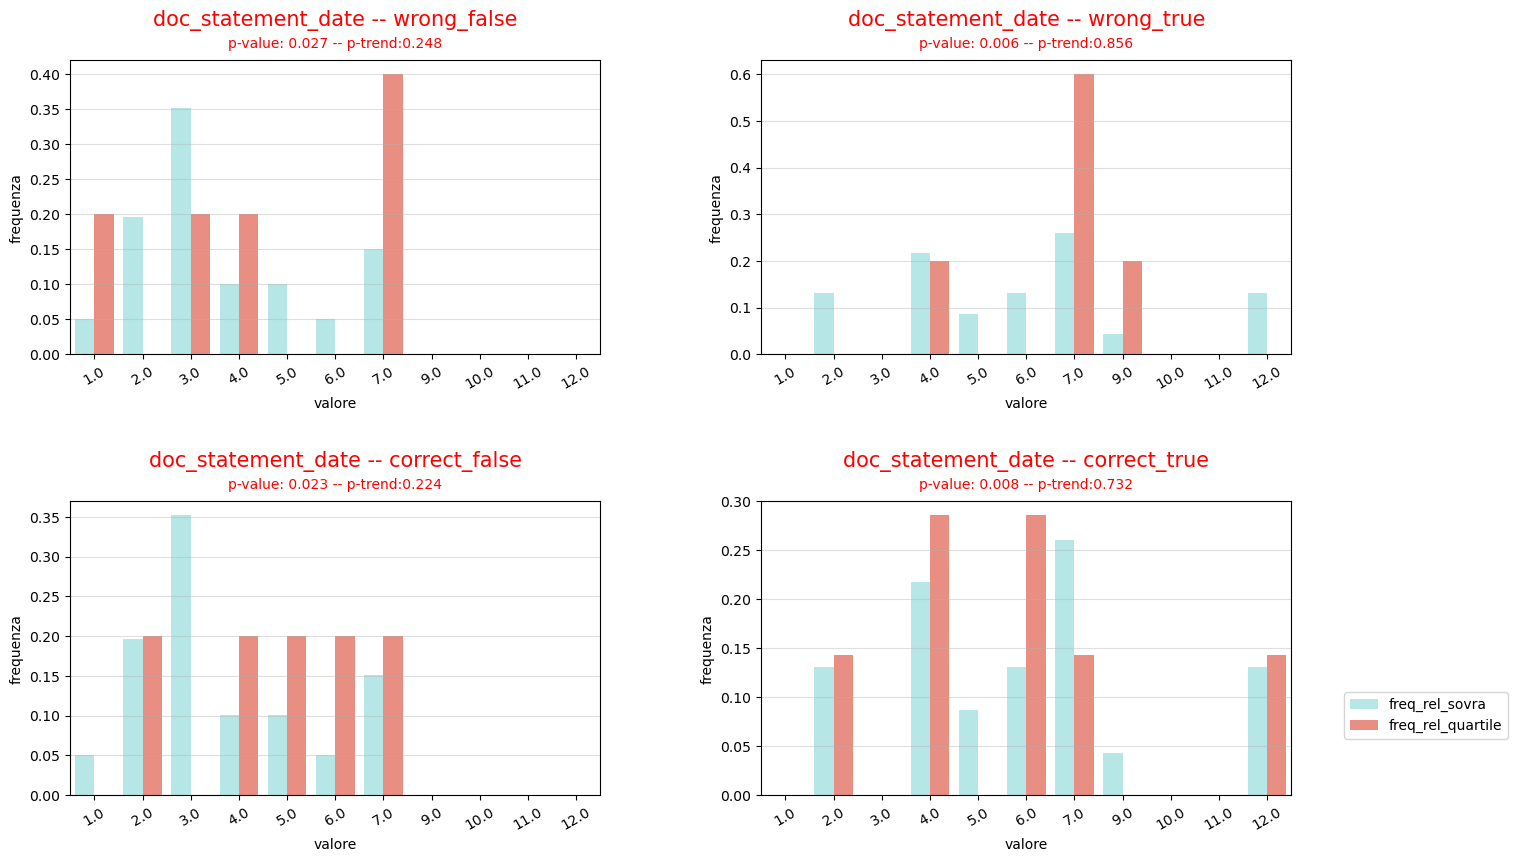

In [30]:
# solo significativi
for dimensione in significativi["dimensione"].unique():
    crea_barplot_all_anova(raccoglitore_dimensioni,tabella_p_value, dimensione,"valore")

voglio indagare di più => divido in:
- trimestri per il date
- in inizio , fine , metà per index

In [31]:
df_analisi["quadrimestre"] = 0
df_analisi["group_index"] = 0

for index, row in df_analisi.iterrows():
    if row["doc_index"] == "0.0" or  row["doc_index"] == "1.0":
        df_analisi.at[index,"group_index"] = "1"
    elif row["doc_index"] == "2.0" or  row["doc_index"] == "3.0" or row["doc_index"] == "4.0" or  row["doc_index"] == "5.0":
        df_analisi.at[index,"group_index"] = "2"
    elif row["doc_index"] == "6.0" or  row["doc_index"] == "7.0":
        df_analisi.at[index,"group_index"] = "3"
    
    if row["doc_statement_date"] < 5:
        df_analisi.at[index,"quadrimestre"] = "1"
    elif row["doc_statement_date"] < 9:
        df_analisi.at[index,"quadrimestre"] = "2"
    elif row["doc_statement_date"] < 13:
        df_analisi.at[index,"quadrimestre"] = "3"
    
    


In [32]:
dimensioni_da_analizzare2 = ["group_index","quadrimestre"]

In [33]:
raccoglitore_dimensioni2 = crea_raccoglitore_dimensioni(df_analisi, dimensioni_da_analizzare2, quartili)

In [34]:
tabella_p_value2 = costruisci_tabella_pvalue_anova(raccoglitore_dimensioni2, dimensioni_da_analizzare2, quartili,ignora_per_ptrend = ["doc_speaker_party"])
significativi2 = filtra_siglificativi(tabella_p_value2, dimensioni_da_analizzare2, quartili, 0.05,"pvalue_quartile_sovra").sort_values(by=["dimensione"], ascending=True)
significativi2

,dimensione,quartile,confronto,valore_pvalue,p_trend
4,group_index,correct_false,pvalue_quartile_sovra,0.040691,0.830052
1,group_index,wrong_false,pvalue_quartile_sovra,0.044608,0.826573


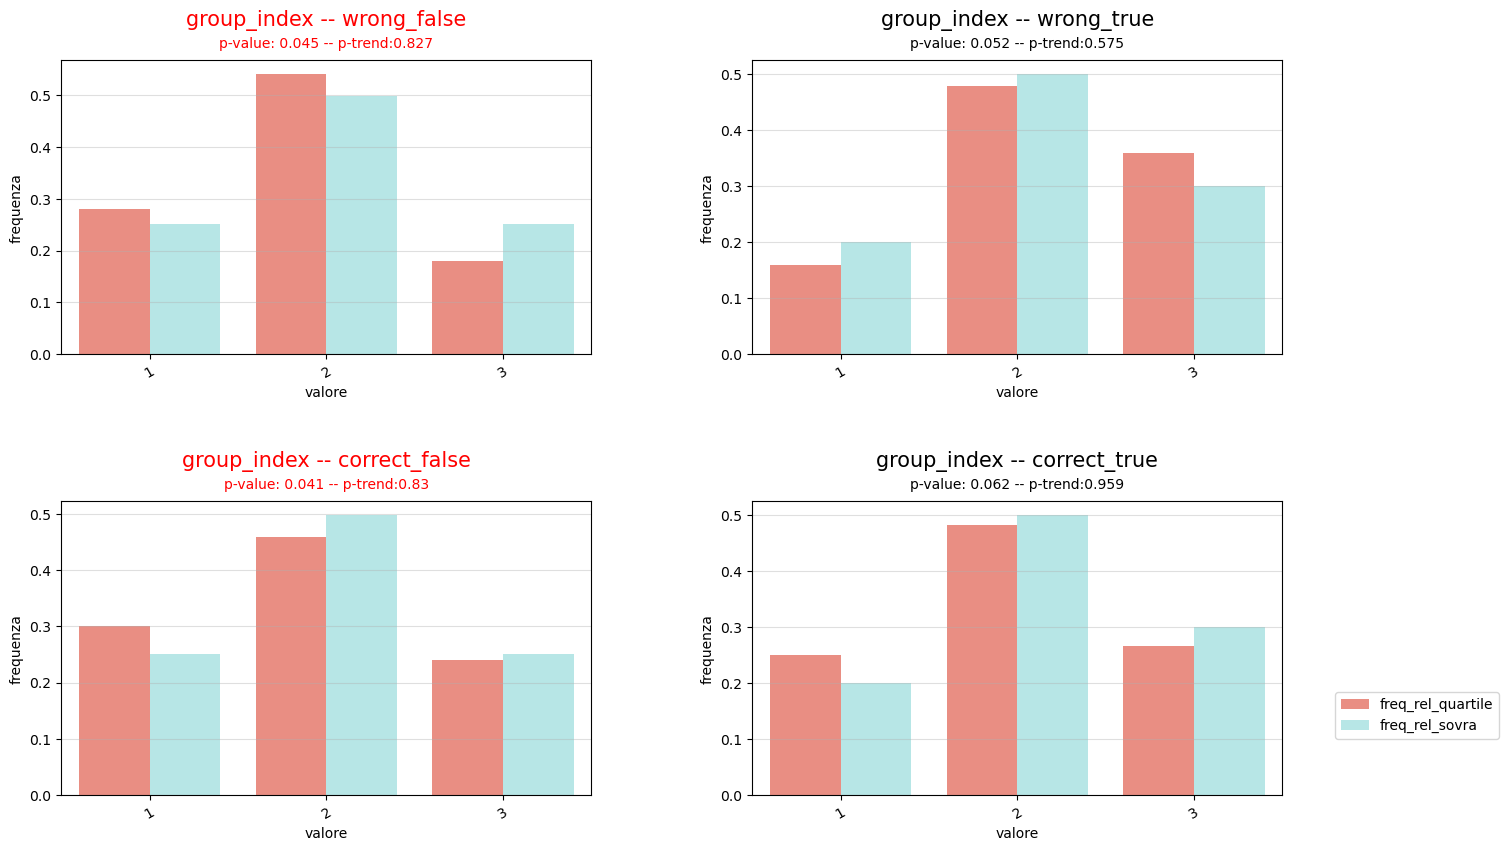

In [35]:
# solo significativi
for dimensione in significativi2["dimensione"].unique():
    crea_barplot_all_anova(raccoglitore_dimensioni2,tabella_p_value2, dimensione,"valore")

## Confronto gruppi

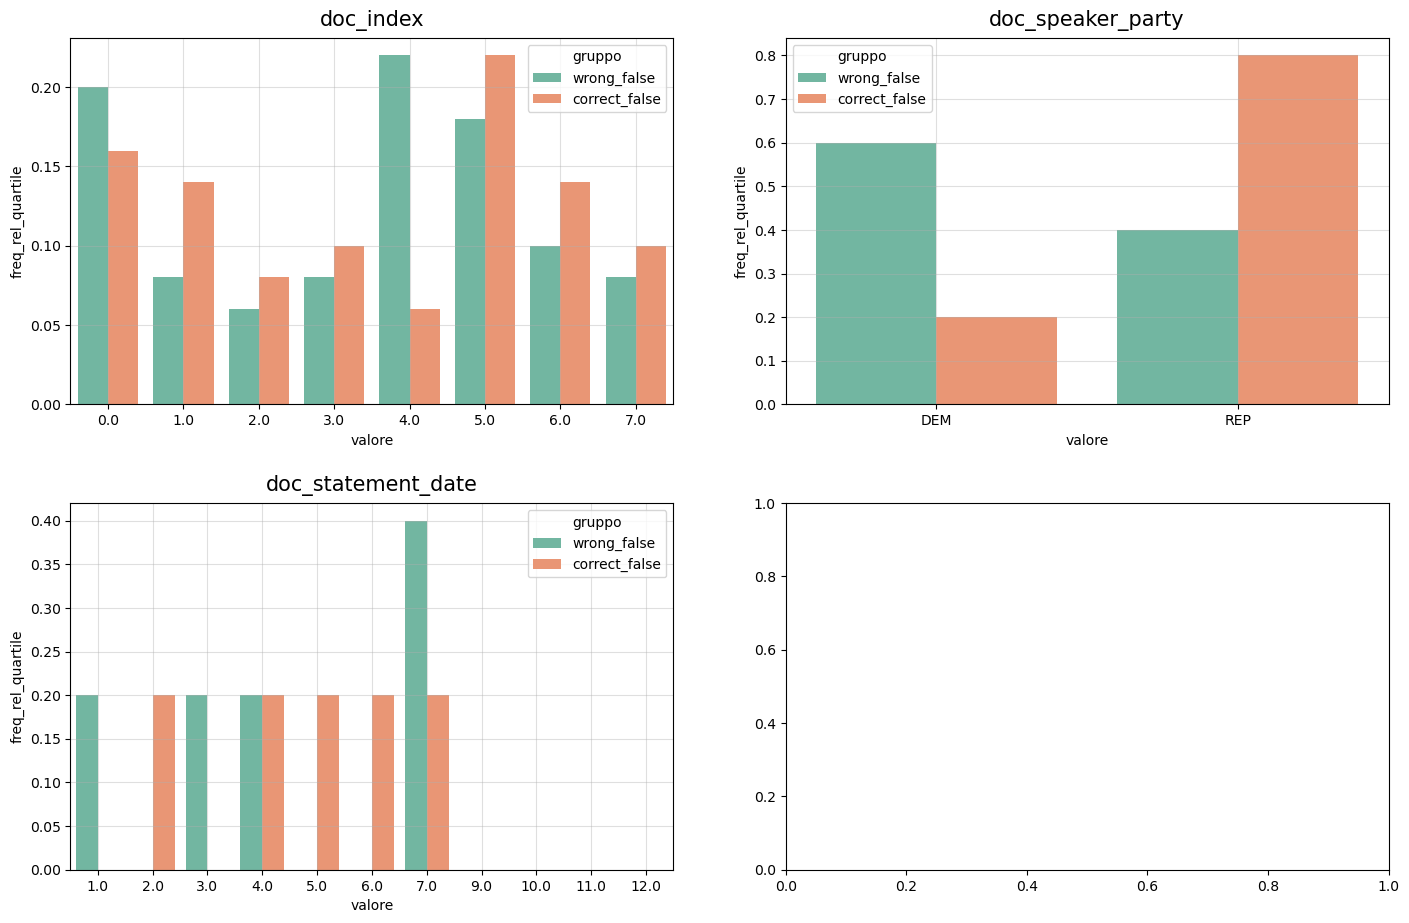

In [29]:
gruppo = ["wrong_false", "correct_false"]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label=False, numero_per_riga = 2)

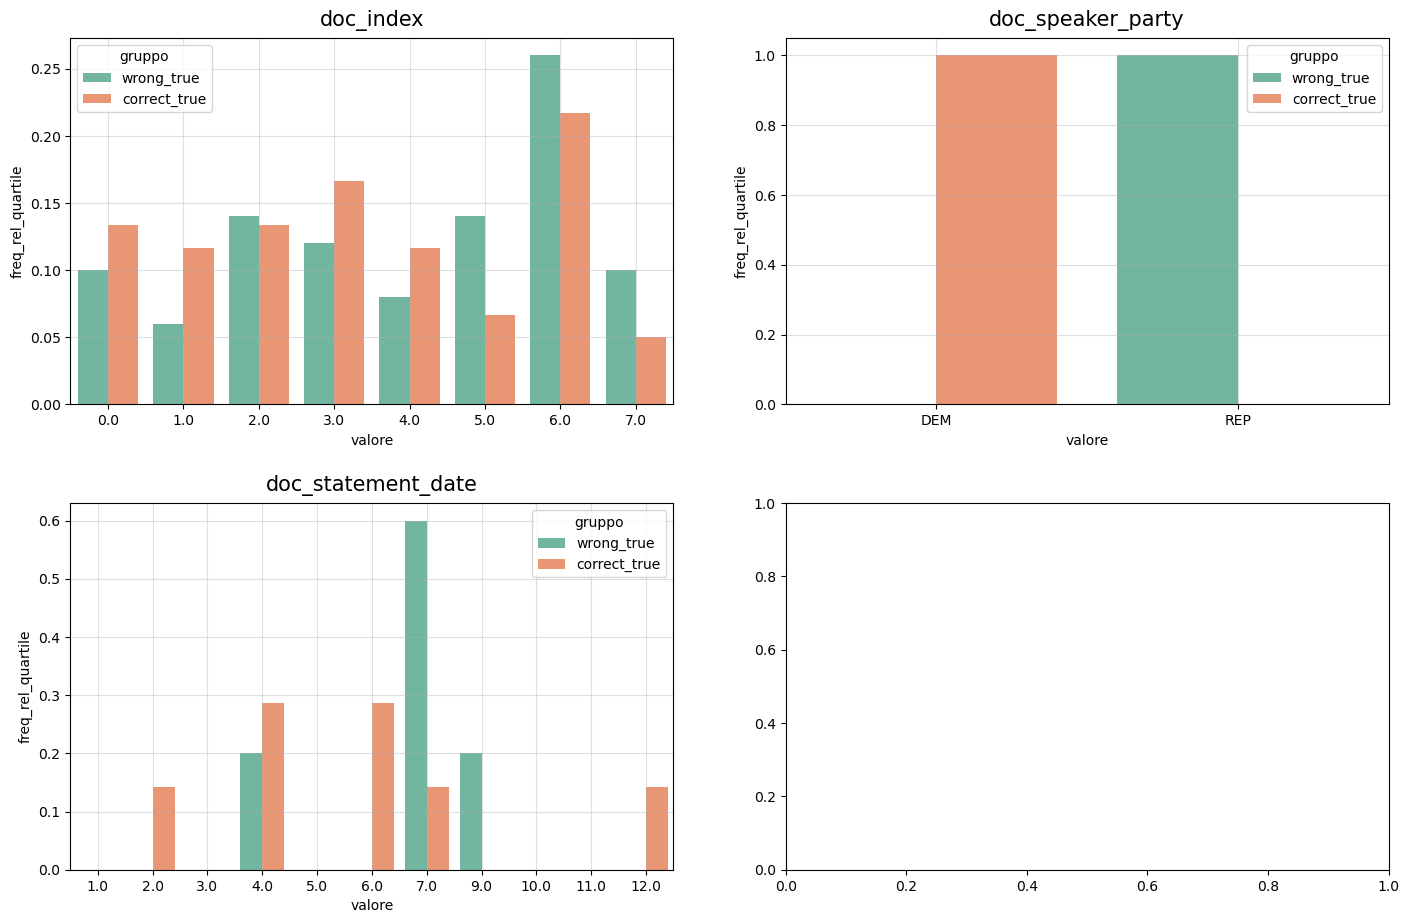

In [30]:
gruppo = ["wrong_true", "correct_true"]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label=False,numero_per_riga = 2)

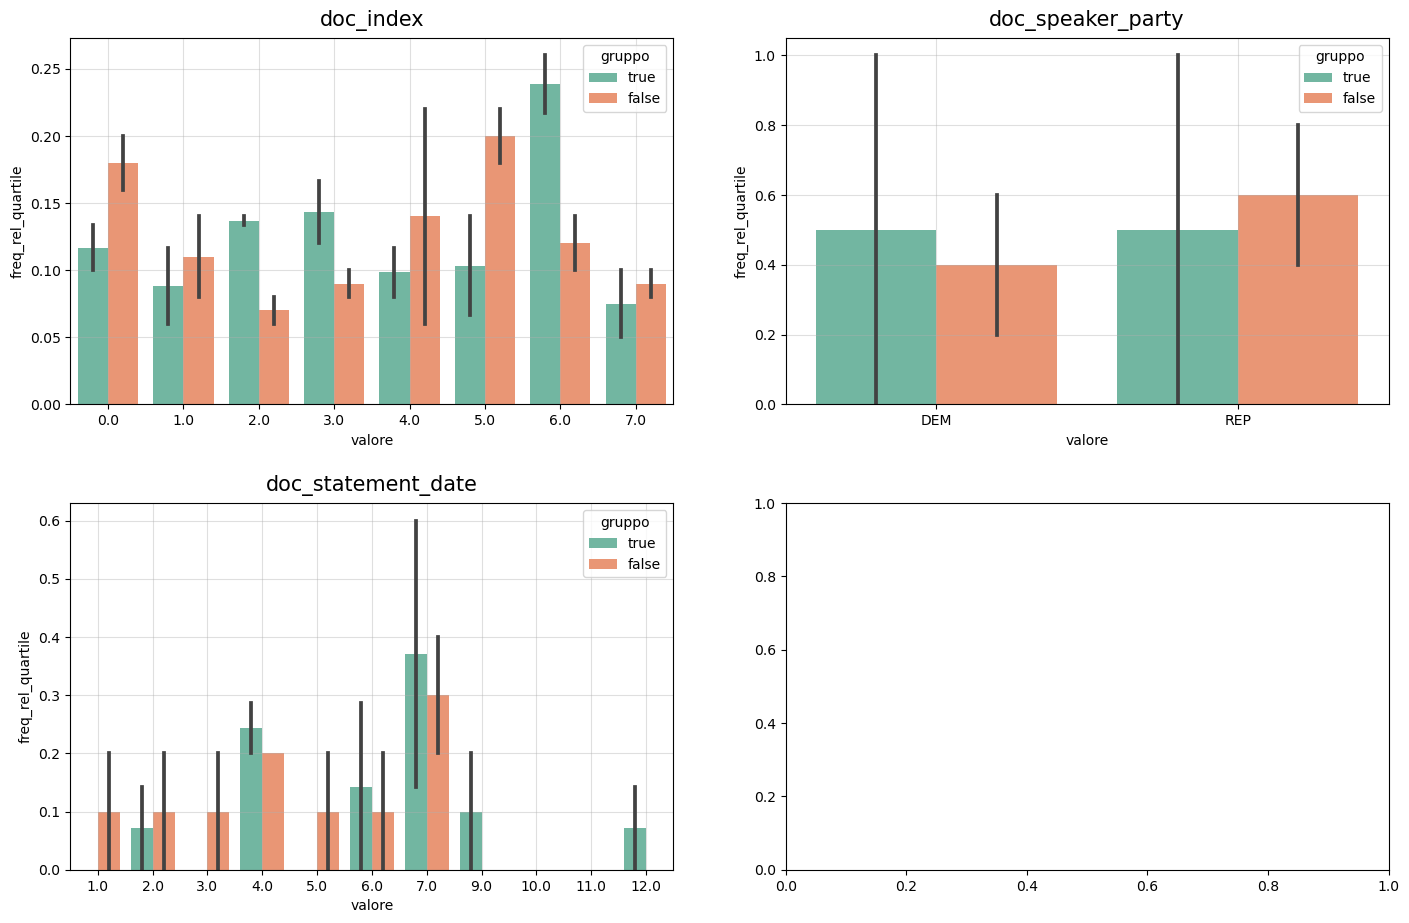

In [31]:
gruppo = [["wrong_true", "correct_true"],["wrong_false", "correct_false"]]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label = False,names = ["true","false"],numero_per_riga = 2)

In [32]:
gruppi_quartili = [["correct_true", "wrong_true"],["wrong_false", "correct_false"]]
name_gruppi = ["true","false"]
calcola_p_value_gruppi_quartili(raccoglitore_dimensioni, dimensioni_da_analizzare, gruppi_quartili,label = False, name_gruppi = name_gruppi, solo_significativi = True)

true doc_index 0.013734855388193513
false doc_speaker_party 0.0028875740683071797
true doc_statement_date 5.633318416090961e-32
false doc_statement_date 3.496566060030392e-08


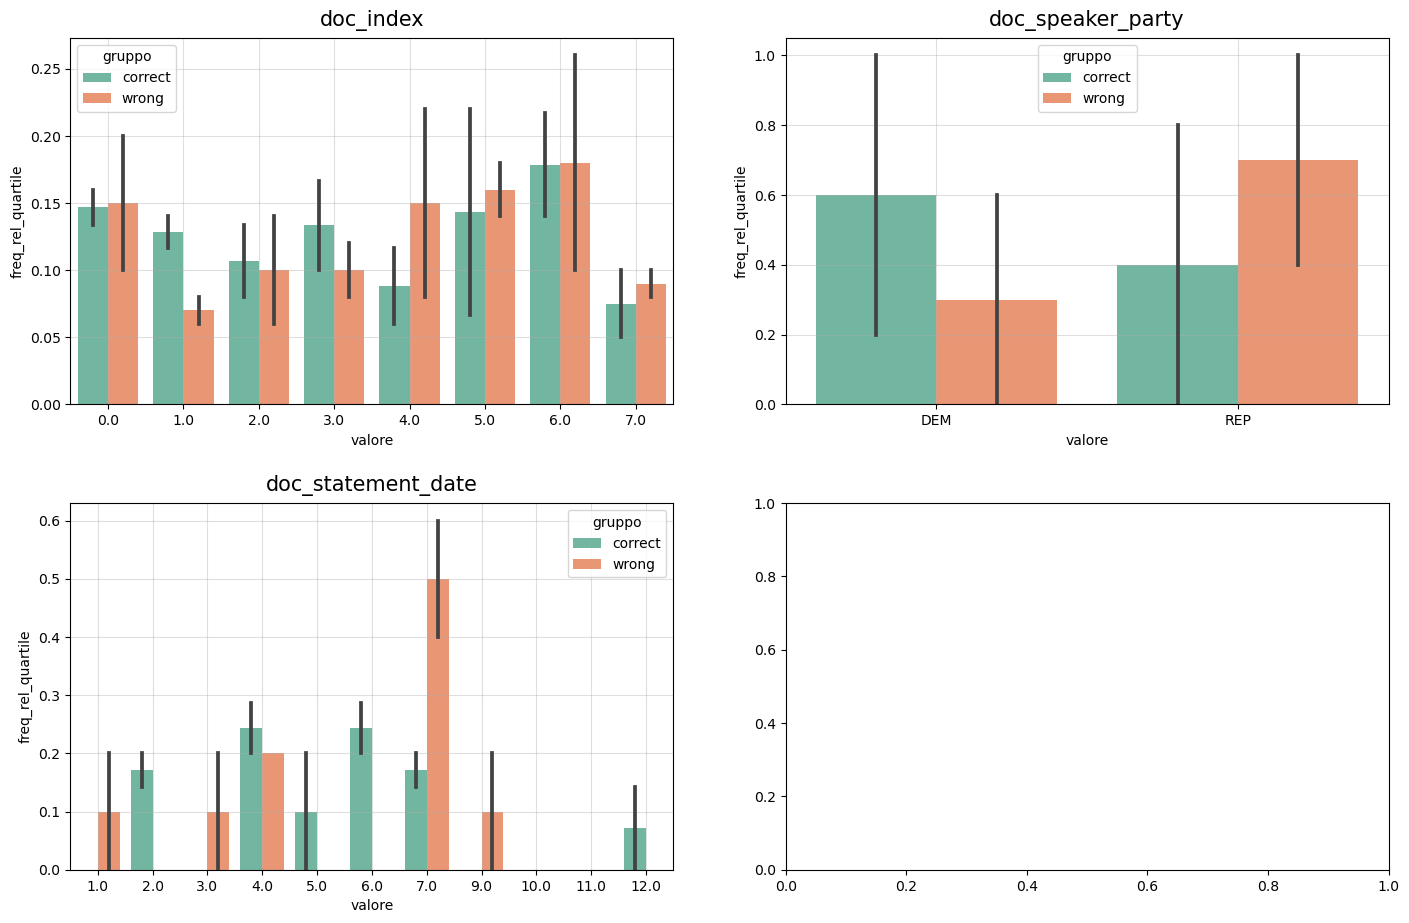

In [33]:
gruppo = [["correct_false", "correct_true"],["wrong_false", "wrong_true"]]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label = False,names = ["correct","wrong"],numero_per_riga = 2)

In [34]:
gruppi_quartili = [["correct_false", "correct_true"],["wrong_false", "wrong_true"]]
name_gruppi = ["correct","wrong"]
calcola_p_value_gruppi_quartili(raccoglitore_dimensioni, dimensioni_da_analizzare, gruppi_quartili,label = False, name_gruppi = name_gruppi, solo_significativi = True)

correct doc_speaker_party 0.03736574296026352
wrong doc_speaker_party 3.8562168969944933e-07
correct doc_statement_date 6.2560433020129024e-15
wrong doc_statement_date 1.3062944818499774e-42


Noto che la dimensione più interessante è doc_speaker_party

In [35]:
df_analisi[["doc_speaker_party","doc_truthfulness_index"]].groupby("doc_speaker_party").mean()

,doc_truthfulness_index
doc_speaker_party,
DEM,2.941538
REP,2.495446


## Analisi del linguaggio naturale

### Distribuzione del numero di parole significative

    parole significative = parole che non sono stop word
    dizionario = inglese

In [36]:
import nltk
from nltk.corpus import stopwords

calcolo:
- numero parole frase => paole singole frase
- numero parole significative => parole che non sono stop word
- percentuale significative rispetto a totale

In [37]:
df_analisi["numero_parole_frase"] = 0
df_analisi["numero_parole_significative"] = 0
df_analisi["percentuale_parole_significative"] = 0

for frase in df_analisi["doc_statement_text"]:
    # Separa la frase in parole
    parole = frase.split()
    # Rimuovi le stopwords inglesi
    stopwords_eng = stopwords.words('english')
    parole_significative = [parola for parola in parole if parola.lower() not in stopwords_eng]
    # Calcola il numero di parole significative
    numero_parole_significative = len(parole_significative)
    
    id = df_analisi.loc[df_analisi["doc_statement_text"] == frase]["doc_id"].unique()[0]
    df_analisi.loc[df_analisi["doc_statement_text"] == frase, "numero_parole_significative"] = numero_parole_significative
    
    lunghezza_frase = len(parole)
    df_analisi.loc[df_analisi["doc_statement_text"] == frase, "numero_parole_frase"] = lunghezza_frase
    
    df_analisi.loc[df_analisi["doc_statement_text"] == frase, "percentuale_parole_significative"] = numero_parole_significative/lunghezza_frase
    

In [38]:
# poiche mi interessano solo gli statement, elimino i duplicati
df_analisi_statement = df_analisi.copy()
df_analisi_statement.drop_duplicates(subset ="doc_statement_text", keep = "first", inplace = True)

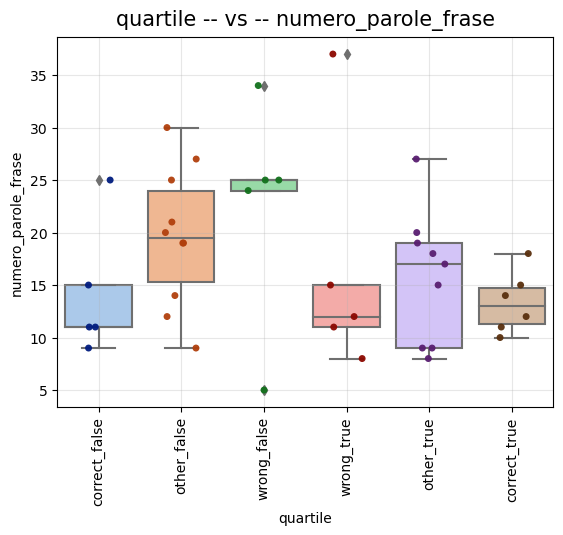

In [39]:
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "numero_parole_frase")

In [40]:
calcola_test_mann(df_analisi_statement, "numero_parole_frase",quartili)

['wrong_false'] ['correct_false' 'other_false'] --> pvalue:  0.2925230710554235
['correct_false'] ['wrong_false' 'other_false'] --> pvalue:  0.13591232518120486
['wrong_true'] ['other_true' 'correct_true'] --> pvalue:  0.7591904948172747
['correct_true'] ['other_true' 'wrong_true'] --> pvalue:  0.6790238901756285


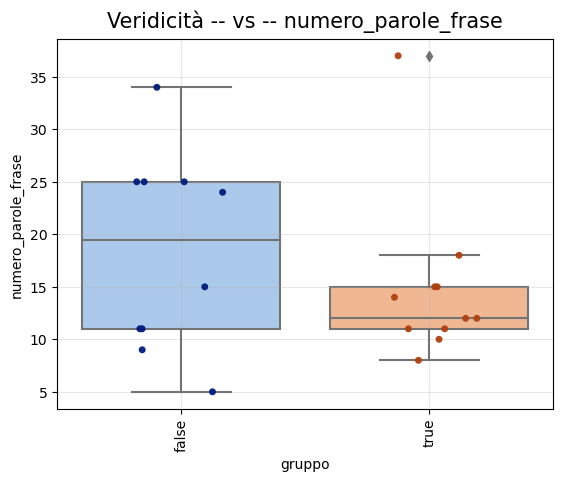

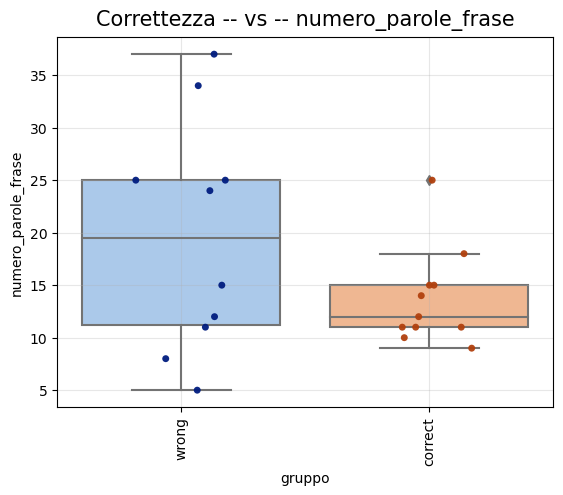

In [41]:
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "numero_parole_frase",gruppi = [["wrong_false", "correct_false"],["wrong_true", "correct_true"]],labels = ["false","true"],titolo = "Veridicità")
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "numero_parole_frase",gruppi = [["wrong_false", "wrong_true"],["correct_true", "correct_false"]],labels = ["wrong","correct"],titolo = "Correttezza")

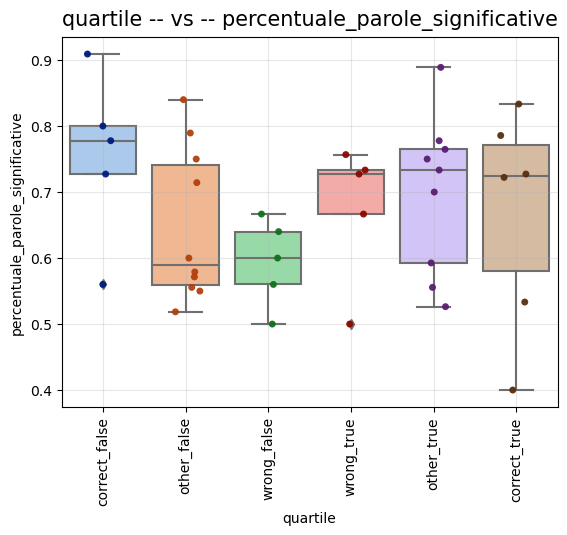

In [42]:
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "percentuale_parole_significative")

In [43]:
calcola_test_mann(df_analisi_statement, "percentuale_parole_significative",quartili)

['wrong_false'] ['correct_false' 'other_false'] --> pvalue:  0.2561293786566847
['correct_false'] ['wrong_false' 'other_false'] --> pvalue:  0.07333605145835306
['wrong_true'] ['other_true' 'correct_true'] --> pvalue:  0.6622822932247326
['correct_true'] ['other_true' 'wrong_true'] --> pvalue:  0.9342167596601569


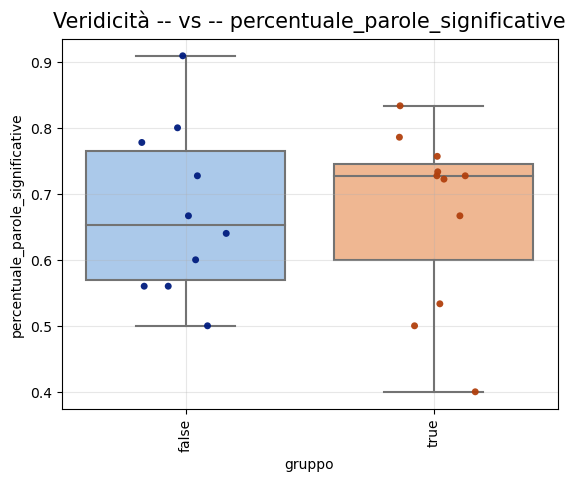

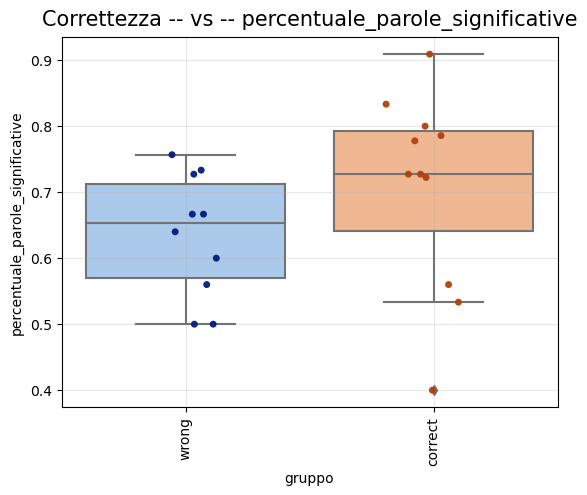

In [44]:
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "percentuale_parole_significative",gruppi = [["wrong_false", "correct_false"],["wrong_true", "correct_true"]],labels = ["false","true"],titolo = "Veridicità")
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "percentuale_parole_significative",gruppi = [["wrong_false", "wrong_true"],["correct_true", "correct_false"]],labels = ["wrong","correct"],titolo = "Correttezza")

### Distribuzione della leggibilit`a (FRE)

In [45]:
import textstat

In [46]:
df_analisi["fre"] = 0

for frase in df_analisi["doc_statement_text"]:
    fre = textstat.flesch_reading_ease(frase)
    
    id = df_analisi.loc[df_analisi["doc_statement_text"] == frase]["doc_id"].unique()[0]
    df_analisi.loc[df_analisi["doc_statement_text"] == frase, "fre"] = fre
    

In [47]:
# poiche mi interessano solo gli statement, elimino i duplicati
df_analisi_statement = df_analisi.copy()
df_analisi_statement.drop_duplicates(subset ="doc_statement_text", keep = "first", inplace = True)

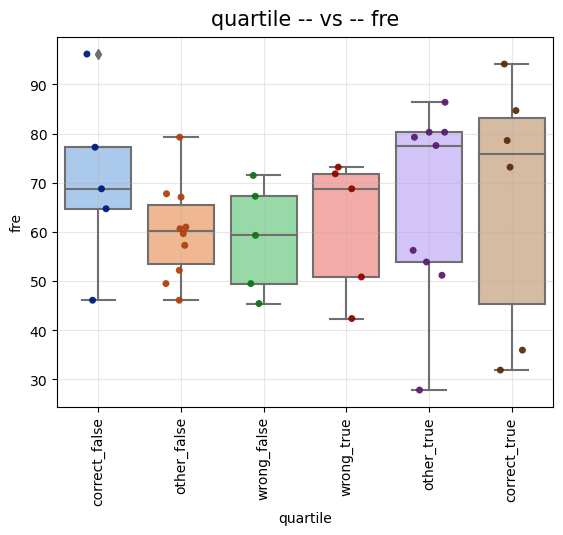

In [48]:
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "fre")

In [49]:
calcola_test_mann(df_analisi_statement, "fre",quartili)

['wrong_false'] ['correct_false' 'other_false'] --> pvalue:  0.4848271022156845
['correct_false'] ['wrong_false' 'other_false'] --> pvalue:  0.17590877328410437
['wrong_true'] ['other_true' 'correct_true'] --> pvalue:  0.2748723341063948
['correct_true'] ['other_true' 'wrong_true'] --> pvalue:  0.6798238825519876


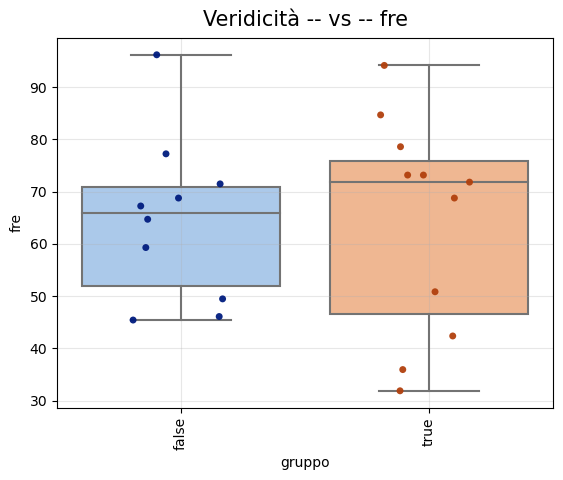

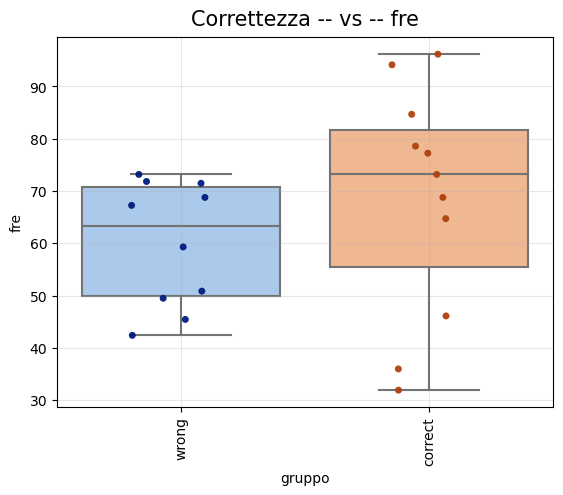

In [50]:
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "fre",gruppi = [["wrong_false", "correct_false"],["wrong_true", "correct_true"]],labels = ["false","true"],titolo = "Veridicità")
crea_boxplot_e_stripplot(df_analisi_statement, "quartile", "fre",gruppi = [["wrong_false", "wrong_true"],["correct_true", "correct_false"]],labels = ["wrong","correct"],titolo = "Correttezza")

### Rapporti tra frequenze relative dei valori del sentimento e soggettività

    sentiment:
    > 0 => positivo
    = 0 => neutro
    < 0 => negativo

    soggettività:
    0 => oggettivo
    1 => soggettivo

In [51]:
from textblob import TextBlob

In [52]:
# aggingo value

df_analisi["sentiment"] = 0
df_analisi["subjectivity"] = 0

for frase in df_analisi["doc_statement_text"]:
    sentiment = TextBlob(frase).sentiment.polarity
    subjectivity = TextBlob(frase).sentiment.subjectivity
    
    id = df_analisi.loc[df_analisi["doc_statement_text"] == frase]["doc_id"].unique()[0]
    df_analisi.loc[df_analisi["doc_statement_text"] == frase, "sentiment"] = sentiment
    df_analisi.loc[df_analisi["doc_statement_text"] == frase, "subjectivity"] = subjectivity

df_analisi["sentiment_label"] = 0
df_analisi["subjectivity_label"] = 0


# aggiungo label in base al valore
for index, row in df_analisi.iterrows():
    if row["sentiment"] > 0:
        df_analisi.loc[index, "sentiment_label"] = "positive"
    elif row["sentiment"] == 0:
        df_analisi.loc[index, "sentiment_label"] = "neutral"
    else:
        df_analisi.loc[index, "sentiment_label"] = "negative"
        
    if row["subjectivity"] >= 0.80:
        df_analisi.loc[index, "subjectivity_label"] = "alta"
    elif row["subjectivity"] >= 0.60:
        df_analisi.loc[index, "subjectivity_label"] = "media-alta"
    elif row["subjectivity"] >= 0.40:
        df_analisi.loc[index, "subjectivity_label"] = "media"
    elif row["subjectivity"] >= 0.20:
        df_analisi.loc[index, "subjectivity_label"] = "media-bassa"
    else:
        df_analisi.loc[index, "subjectivity_label"] = "bassa"

In [53]:
dimensioni_da_analizzare = ["sentiment_label", "subjectivity_label"]
ordine_personalizzato = ["bassa","media-bassa","media","media-alta","alta"]

In [54]:
raccoglitore_dimensioni = crea_raccoglitore_dimensioni(df_analisi, dimensioni_da_analizzare, quartili)

In [55]:
raccoglitore_dimensioni["sentiment_label"]["correct_false"]

,valore,freq_ass_all,freq_ass_sovra,freq_ass_quartile,freq_rel_all,freq_rel_sovra,freq_rel_quartile
2,negative,200,40,10,0.166806,0.201005,0.2
0,neutral,529,119,40,0.441201,0.597990,0.8
1,positive,470,40,0,0.391993,0.201005,0.0


In [56]:
mapping_per_ptrend = {
    "sentiment_label": {
        "negative" : -1,
        "neutral" : 0,
        "positive" : 1
        
    },
    "subjectivity_label": {
        "bassa" : 0,
        "media-bassa" : 1,
        "media" : 2,
        "media-alta" : 3,
        "alta" : 4
    
    }
}

In [57]:
#tabella_p_value = costruisci_tabella_pvalue(raccoglitore_dimensioni, dimensioni_da_analizzare, quartili,usa_mapping = True, mapping_per_ptrend = mapping_per_ptrend)
tabella_p_value = costruisci_tabella_pvalue_anova(raccoglitore_dimensioni, dimensioni_da_analizzare, quartili,usa_mapping = True, mapping_per_ptrend = mapping_per_ptrend)
significativi = filtra_siglificativi(tabella_p_value, dimensioni_da_analizzare, quartili, 0.05,"pvalue_quartile_sovra")
significativi

,dimensione,quartile,confronto,valore_pvalue,p_trend


In [58]:
#for dimensione in significativi["dimensione"].unique():
#    crea_barplot_quartili(raccoglitore_dimensioni, dimensione,"valore")

In [59]:
for dimensione in significativi["dimensione"].unique():
    crea_barplot_all(raccoglitore_dimensioni,tabella_p_value, dimensione,"valore")

## Analisi regressione

In [60]:
dimensioni_da_analizzare = ["sentiment",
                            "subjectivity",
                            "numero_parole_frase",
                            "doc_index","doc_statement_date","fre"]

sentiment


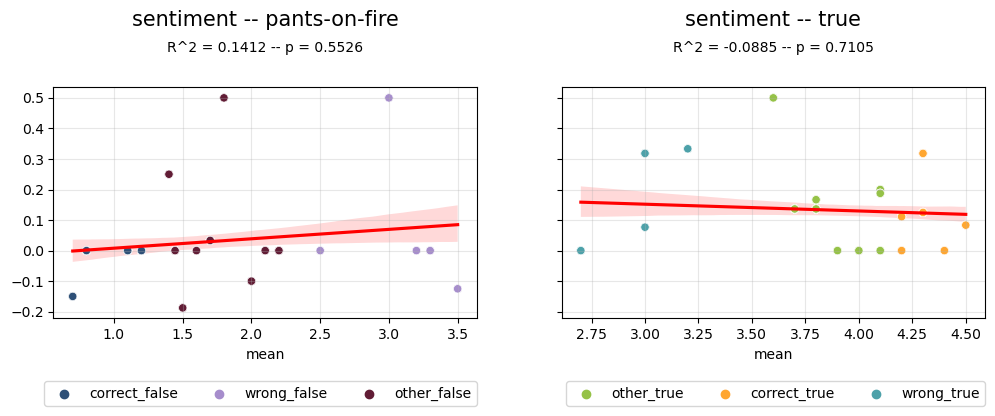

subjectivity


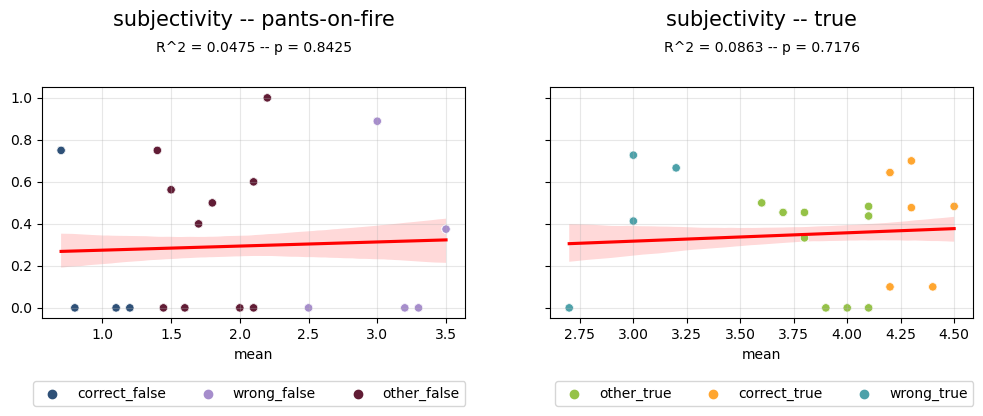

numero_parole_frase


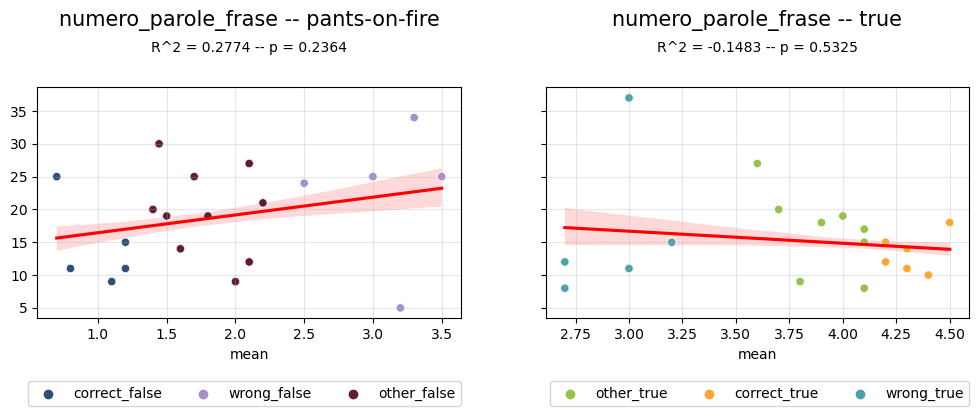

doc_index


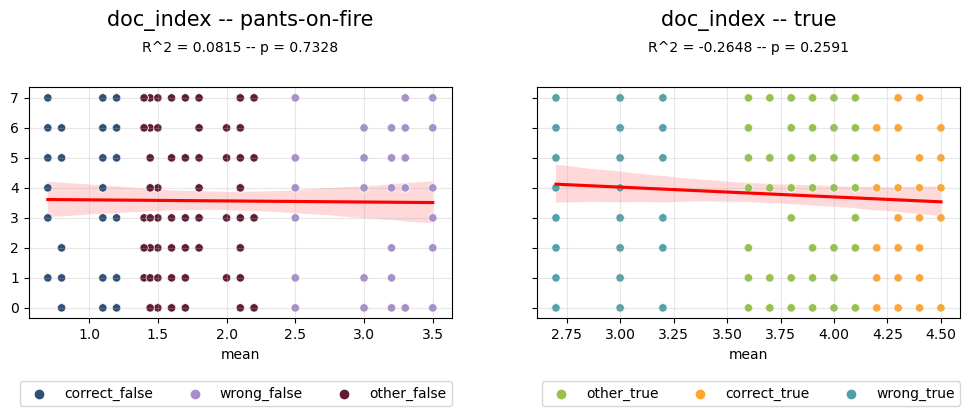

doc_statement_date


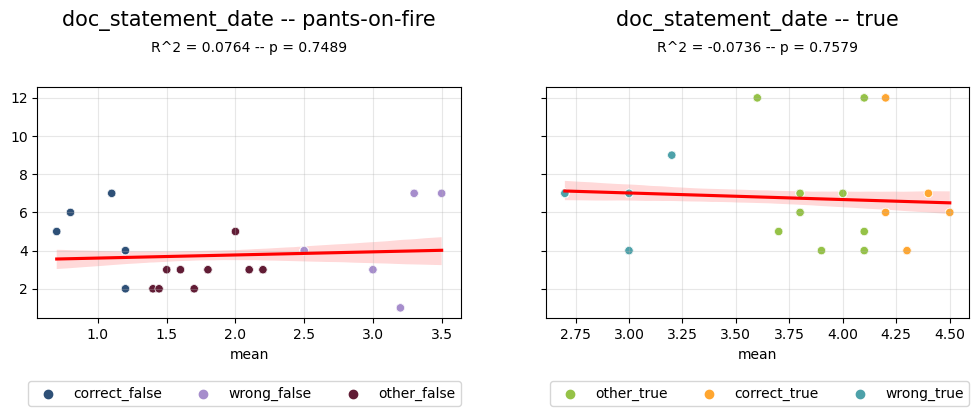

fre


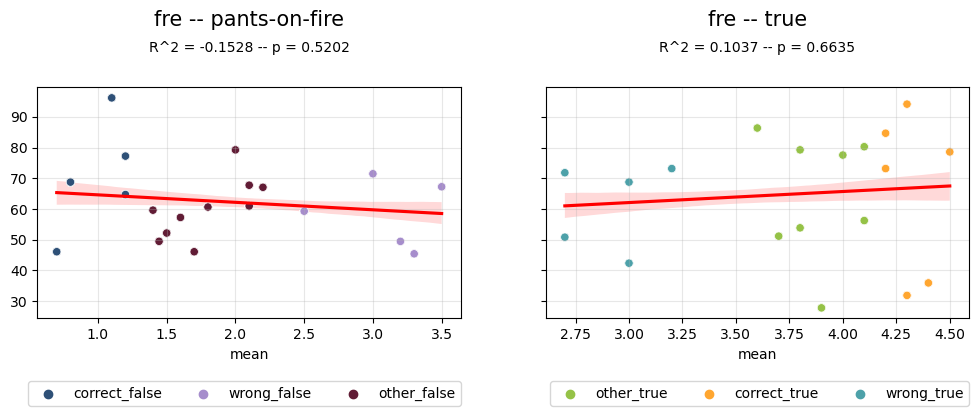

In [61]:
# senza mean
plot_regressione_lineare(df_analisi,dimensioni_da_analizzare)

In [62]:
df_analisi_con_mean = df_analisi.copy()
for dimensione in dimensioni_da_analizzare:
    print(dimensione[:-1]+"_mean")
    df_analisi_con_mean[dimensione[:-1]+"_mean"] = 0

for statement in df_analisi_con_mean["doc_id"].unique():
    for dim in dimensioni_da_analizzare:
        mean = np.asarray(df_analisi_con_mean[df_analisi_con_mean["doc_id"] == statement][dim],dtype = np.float64).mean()
        df_analisi_con_mean.loc[df_analisi_con_mean["doc_id"] == statement, dim[:-1]+"_mean"] = mean 

sentimen_mean
subjectivit_mean
numero_parole_fras_mean
doc_inde_mean
doc_statement_dat_mean
fr_mean


sentiment


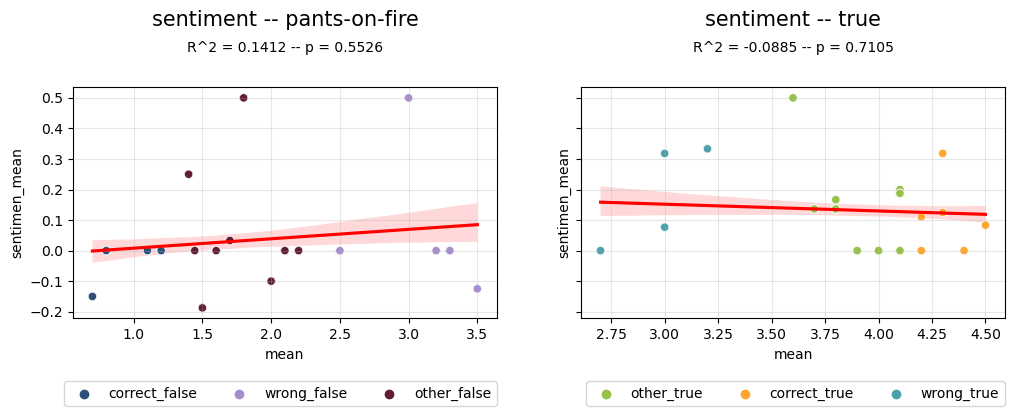

subjectivity


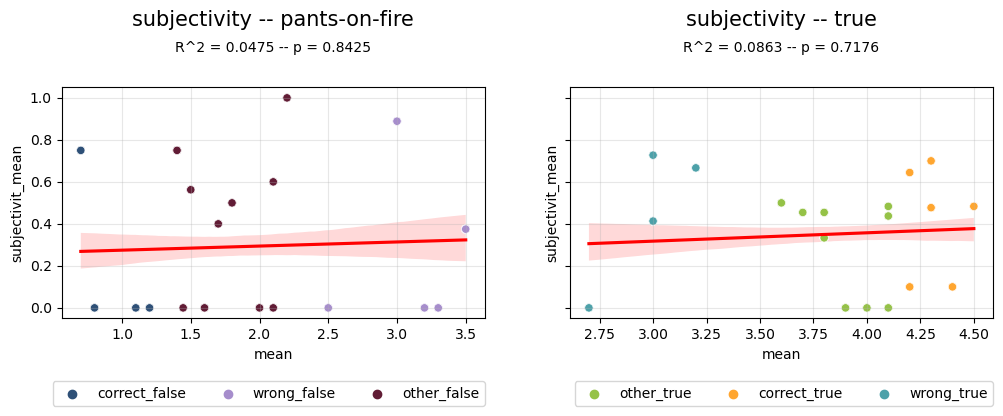

numero_parole_frase


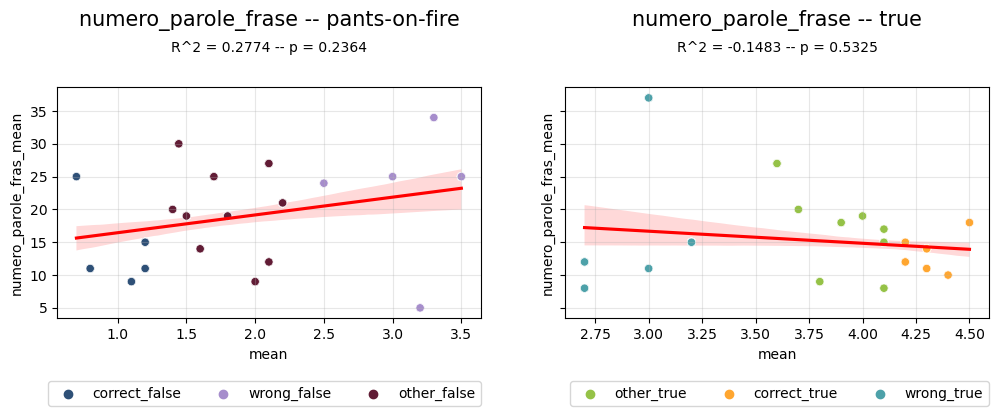

doc_index


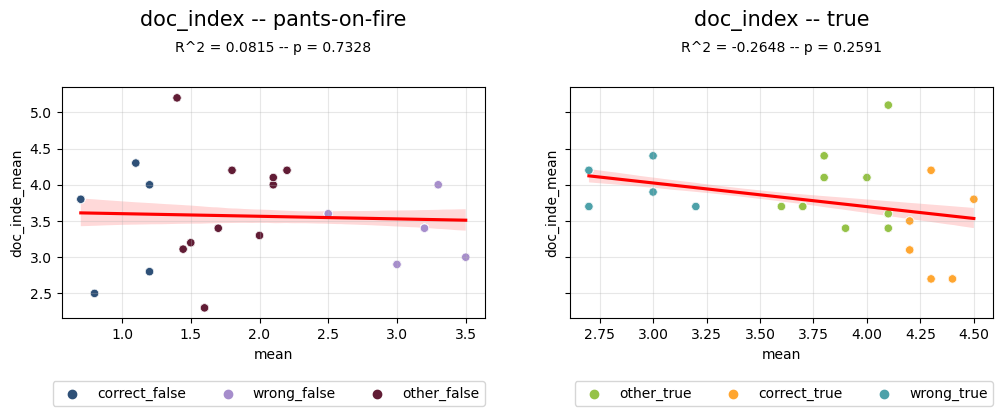

doc_statement_date


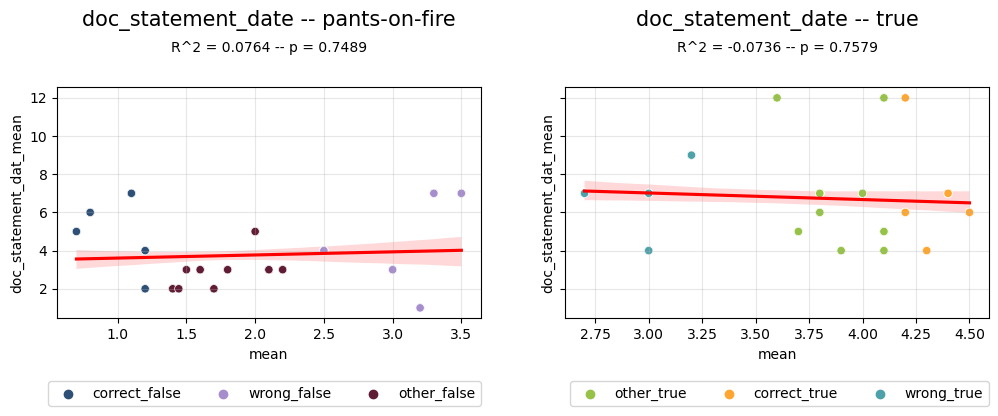

fre


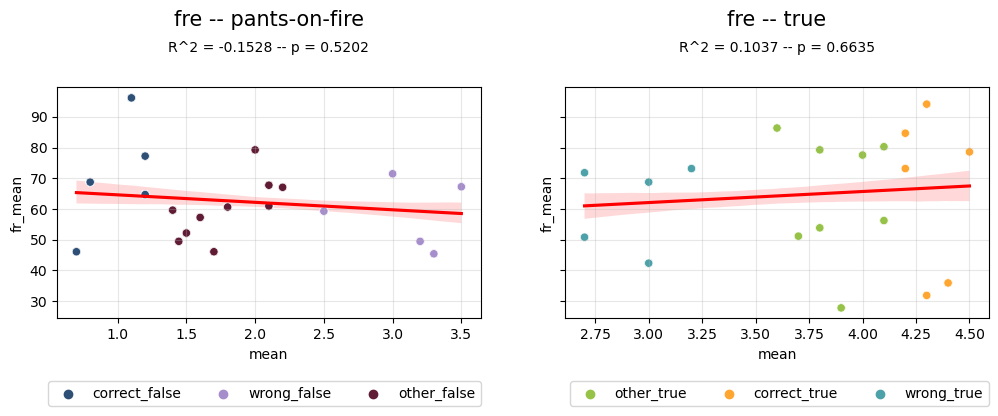

In [63]:
# con mean
plot_regressione_lineare_RQ(df_analisi_con_mean,dimensioni_da_analizzare,1)

## Analisi medie

In [64]:
# verifico se son tutti uguali => poichè son tutti uguali posso fare drop_by_doc_id
for doc_id in df_analisi_con_mean["doc_id"].unique():
    for dim in dimensioni_da_analizzare:
        if len(df_analisi_con_mean[df_analisi_con_mean["doc_id"] == doc_id][dim].unique()) > 1:
            print(doc_id, dim)
    if len(df_analisi_con_mean[df_analisi_con_mean["doc_id"] == doc_id]["quartile"].unique()) > 1:
        print(doc_id,df_analisi_con_mean[df_analisi_con_mean["doc_id"] == doc_id]["quartile"].unique())

joni-ernst-target-describing-11th-hour-obama-rule- doc_index
gop-challenger-overstates-parole-boards-record-und doc_index
greene-twists-logic-and-facts-pedophilia-charge-ag doc_index
barnes-partially-right-claim-johnson-has-received- doc_index
david-jolly-says-kathleen-peters-wont-take-stand-r doc_index
john-boehner-says-stimulus-bill-was-rushed-passage doc_index
ron-desantis-exaggerates-outstanding-graduate-stud doc_index
ohios-mandel-repeats-false-claim-stolen-2020-elect doc_index
lauren-boebert-wrong-founding-fathers-intent-exper doc_index
hard-pin-down-growing-cost-unused-border-materials doc_index
yes-tax-break-ron-johnson-pushed-2017-has-benefite doc_index
suozzi-calling-hochul-interim-governor-s-misleadin doc_index
fact-checking-claim-about-number-immigrants-becomi doc_index
nikki-frieds-ad-misleads-crists-position-abortion- doc_index
marjorie-taylor-greene-shared-edited-image-highlan doc_index
virginia-975-abortions-occur-15-weeks-pregnancy-or doc_index
susan-collins-says-year-

non sono uguali quinidi mi fermo

## Analisi scarto

In [65]:
dimensioni_da_analizzare = ["doc_index", 
                            "doc_speaker_party",
                            "doc_statement_date"] + ["numero_parole_significative", 
                            "fre",
                            "sentiment",
                            "subjectivity",
                            "numero_parole_frase"]

In [66]:
analizza_scarto(df_analisi,quartili,dimensioni_da_analizzare,solo_quartile_vs_sovra = True)

quartile vs sovra =>  doc_speaker_party wrong_true -> 0.017613387982186462


## Analisi bias

In [67]:
# doc_truthfulness_index

# confronto a sigolo vs tutti altri

dimensioni_da_analizzare = ["doc_index", "doc_speaker_party",
                            "doc_statement_date",
                            "numero_parole_significative",
                            "fre",
                            "sentiment_label",
                            "subjectivity_label"]

for dimensione in dimensioni_da_analizzare:
    
    for value in df_analisi[dimensione].unique():
        group1 = df_analisi[df_analisi[dimensione] == value]["doc_truthfulness_index"]
        # tutti
        group2 = df_analisi[df_analisi[dimensione] != value]["doc_truthfulness_index"]
        p = test_mann_whitney_u(group1,group2)
        if p < 0.05:
            print(dimensione,value,p)

doc_speaker_party DEM 4.565785150836475e-06
doc_speaker_party REP 4.565785150836475e-06
doc_statement_date 4.0 0.002523857059023339
doc_statement_date 12.0 0.03191483507669884
doc_statement_date 2.0 1.8291881019995e-06
numero_parole_significative 10 0.0007681057002256079
numero_parole_significative 9 0.004158997614005592
numero_parole_significative 14 0.01601480166104866
numero_parole_significative 15 0.005737043531636827
numero_parole_significative 18 0.016223780174728742
fre 85.02 0.014582134324346453
fre 77.23 0.007207675196194772
fre 77.57 0.013738523694966264
fre 59.64 0.0002446194811783005
fre 60.31 0.015490931142116712
fre 46.1 0.0007331825617801705
fre 29.52 0.0004770056461583148
fre 64.71 0.0038362823403101723
fre 46.78 0.04139682971837982
fre 56.25 0.0069088723317487525
fre 43.39 0.04719463522886346
fre 78.59 0.0003932039542660512
fre 52.19 0.022334447357219064
fre 71.14 0.02978763335632958
fre 27.83 0.025037047378520954
fre 79.6 0.009082215571486271
fre 73.17 0.0111636240463

In [68]:
# doc_truthfulness_index

# confronto a coppie

dimensioni_da_analizzare = ["doc_index", "doc_speaker_party",
                            "doc_statement_date",
                            "numero_parole_significative",
                            "fre",
                            "sentiment_label",
                            "subjectivity_label"]

for dimensione in dimensioni_da_analizzare:
    
    for value in df_analisi[dimensione].unique():
        group1 = df_analisi[df_analisi[dimensione] == value]["doc_truthfulness_index"]
        for value2 in df_analisi[dimensione].unique():
            if value != value2:
                group2 = df_analisi[df_analisi[dimensione] == value2]["doc_truthfulness_index"]
                p = test_mann_whitney_u(group1,group2)
                if p < 0.05:
                    print(dimensione,value,value2,p)


doc_speaker_party DEM REP 4.565785150836475e-06
doc_speaker_party REP DEM 4.565785150836475e-06
doc_statement_date 3.0 4.0 0.0011955466148185396
doc_statement_date 3.0 12.0 0.005728039946953693
doc_statement_date 3.0 2.0 0.0020949013929864894
doc_statement_date 6.0 4.0 0.00886234086298026
doc_statement_date 6.0 12.0 0.028541838394619882
doc_statement_date 6.0 2.0 5.720193322648154e-05
doc_statement_date 4.0 3.0 0.0011955466148185396
doc_statement_date 4.0 6.0 0.00886234086298026
doc_statement_date 4.0 5.0 0.03362375761328176
doc_statement_date 4.0 7.0 0.020732530719122753
doc_statement_date 4.0 2.0 1.343859055142526e-07
doc_statement_date 4.0 11.0 0.005518183867113818
doc_statement_date 5.0 4.0 0.03362375761328176
doc_statement_date 5.0 2.0 9.473572879291415e-06
doc_statement_date 7.0 4.0 0.020732530719122753
doc_statement_date 7.0 2.0 3.5740630048445772e-06
doc_statement_date 1.0 2.0 0.004054713654783149
doc_statement_date 12.0 3.0 0.005728039946953693
doc_statement_date 12.0 6.0 0.02

In [69]:
dimensioni_da_analizzare = ["doc_index", "doc_speaker_party",
                            "doc_statement_date",
                            "numero_parole_significative",
                            "fre",
                            "sentiment_label",
                            "subjectivity_label"]

for dimensione in ["sentiment_label"]:
    print(df_analisi[[dimensione,"doc_truthfulness_index"]].groupby(dimensione).mean())

                 doc_truthfulness_index
sentiment_label                        
negative                       2.505000
neutral                        2.741021
positive                       2.831915


# Analisi parole

In [70]:
testi = df_analisi["doc_statement_text"].str.cat(sep=' ')
lista_parole = testi.split() 

In [71]:
import re

# tolgo cose che non sono lettere

for i in range(len(lista_parole)):
    lista_parole[i] = re.sub(r'[^a-zA-Z]', '', lista_parole[i]) 

lista_parole 

['The',
 'Obama',
 'administration',
 'issued',
 'an',
 'thhour',
 'rule',
 'that',
 'entrenches',
 'federal',
 'family',
 'planning',
 'funding',
 'for',
 'Planned',
 'Parenthood',
 'Weve',
 'got',
 'a',
 'parole',
 'board',
 'right',
 'now',
 'that',
 'has',
 'released',
 '',
 'cop',
 'killers',
 'in',
 'the',
 'last',
 'two',
 'years',
 'under',
 'Hochul',
 'Says',
 'Sens',
 'Lisa',
 'Murkowski',
 'Susan',
 'Collins',
 'and',
 'Mitt',
 'Romney',
 'are',
 'propedophile',
 'Says',
 'US',
 'Sen',
 'Ron',
 'Johnson',
 'his',
 'prospective',
 'opponent',
 'has',
 'received',
 '',
 'million',
 'from',
 'the',
 'gun',
 'lobby',
 'Kathleen',
 'Peters',
 'refuses',
 'to',
 'take',
 'a',
 'stand',
 'to',
 'repeal',
 'Obamacare',
 'Members',
 'of',
 'Congress',
 'did',
 'not',
 'have',
 'three',
 'days',
 'to',
 'read',
 'the',
 'bill',
 'when',
 'the',
 'stimulus',
 'was',
 'rushed',
 'into',
 'law',
 'The',
 'student',
 'debt',
 'that',
 'is',
 'out',
 'there',
 'almost',
 '',
 'of',
 'it',


In [72]:
# inizializzo dizionario
frequenza_parole = {}

for parola in lista_parole:
    frequenza_parole[parola] = { "pants-on-fire" : [0,0,0],
                                 "other":  [0,0,0],
                                 "true":  [0,0,0],
                                 "wrong_false":  [0,0,0],
                                 "other_false": [0,0,0],
                                 "correct_false":  [0,0,0],
                                 "wrong_true":  [0,0,0],
                                 "other_true":  [0,0,0],
                                 "correct_true":  [0,0,0],
                                 "all" : [0,0,0],
        
    }

In [73]:
# riempio dizionario

for index, row in df_analisi.iterrows():
    
    for parola in row["doc_statement_text"].split():
        parola = re.sub(r'[^a-zA-Z]', '', parola)
        frequenza_parole[parola]["all"][0] += 1  
        if row["sovra"] == "true":
            
            # frequenza assoluta
            frequenza_parole[parola]["true"][0] += 1
            frequenza_parole[parola][row["quartile"]][0] += 1
            # frequenza relativa
            frequenza_parole[parola]["true"][1] = frequenza_parole[parola]["true"][0] / frequenza_parole[parola]["all"][0]
            frequenza_parole[parola][row["quartile"]][1] = frequenza_parole[parola][row["quartile"]][0] / frequenza_parole[parola]["all"][0]
            
        elif row["sovra"] == "pants-on-fire":
            # frequenza assoluta
            frequenza_parole[parola]["pants-on-fire"][0] += 1
            frequenza_parole[parola][row["quartile"]][0] += 1
            # frequenza relativa
            frequenza_parole[parola]["pants-on-fire"][1] = frequenza_parole[parola]["pants-on-fire"][0] / frequenza_parole[parola]["all"][0]
            frequenza_parole[parola][row["quartile"]][1] = frequenza_parole[parola][row["quartile"]][0] / frequenza_parole[parola]["all"][0]
            
        else:
            frequenza_parole[parola]["other"][0] += 1
            frequenza_parole[parola]["other"][1] = frequenza_parole[parola]["other"][0] / frequenza_parole[parola]["all"][0]
            





In [74]:
for parola in frequenza_parole.keys():
    for quartile in frequenza_parole[parola].keys() :
        if quartile != "all":
            if quartile == "pants-on-fire" or quartile == "true":
                frequenza_parole[parola][quartile][2] = df_analisi[(df_analisi["doc_statement_text"].str.contains(parola)) & (df_analisi["sovra"] == quartile)]["doc_truthfulness_index"].mean()
            else:
                frequenza_parole[parola][quartile][2] = df_analisi[(df_analisi["doc_statement_text"].str.contains(parola)) & (df_analisi["quartile"] == quartile)]["doc_truthfulness_index"].mean()
        else:
            frequenza_parole[parola][quartile][2] = df_analisi[(df_analisi["doc_statement_text"].str.contains(parola))]["doc_truthfulness_index"].mean()

In [75]:
interessanti = {}

for parola in lista_parole:
    for quartile in ["wrong_false","correct_false","wrong_true","correct_true"] :
        if frequenza_parole[parola][quartile][1] > 0.5 and frequenza_parole[parola][quartile][0] > 10:
            interessanti[parola] = [frequenza_parole[parola][quartile][1],frequenza_parole[parola][quartile][0],quartile, frequenza_parole[parola][quartile][2]]

CI sono parole che compaiono solo nei quartili o che compaiono nella loro interezza

In [76]:
interessanti

{'items': [1.0, 20, 'wrong_true', 3.0],
 'Schimel': [1.0, 20, 'wrong_true', 3.0],
 'taking': [0.6666666666666666, 20, 'wrong_true', 3.1],
 'likely': [0.6666666666666666, 20, 'correct_true', 4.35],
 'as': [0.7407407407407407, 20, 'correct_false', 0.8666666666666667],
 'die': [1.0, 20, 'correct_true', 4.35],
 'should': [0.5714285714285714, 20, 'wrong_false', 3.3],
 'Super': [1.0, 20, 'wrong_true', 3.2],
 'ask': [1.0, 20, 'wrong_false', 3.3],
 'permission': [1.0, 20, 'wrong_false', 3.3],
 'youre': [1.0, 20, 'correct_true', nan]}

## Salvo DataFrame

In [77]:
df_analisi.to_csv(index=False, path_or_buf = "../../Datasets/df_Q2.csv")